<a href="https://colab.research.google.com/github/gzholtkevych/CoDeSim/blob/main/CoDeSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Collective Decision-making Simulation Framework**
The project is devoted to studying mechanisms of collective decision-making based on computer simulation.



## **Decision-making Processes**
In the project context, we consider decision-making as choosing an option from an option set $V$.
Of course, the decisionmaker can refuse a choice.
The last can be considered as choosing a special option not belonging to $V$.
This special option is denoted by $\bot$, and the option set extended by the special option $\bot$ is denoted by $\overline V$ below.  

All of the aforesaid is summing in the next assumption.

***Simulation Assumption 1.***
Some finite set $V$ of options containing at least two elements and the special option $\bot$ called the disclaimer such that $\bot\notin V$ are given and fixed.
The full set of options is $\overline V=\{\bot\}\cup V$.

In [1]:
from typing import Dict, List

DISCLAIMER:int = 0

def define_options(*args):
    """creates option set"""
    if not args:
        raise ValueError('Option set is undefined.')
        
    # raises exception if at list one element 
    # of args is not of type str
    for element in args:
        if not isinstance(element, str):
            raise TypeError(f'{element} in args is not of type str.')
        
    # define default options
    temp_options:Dict[int, str] = {DISCLAIMER: "DISCLAIMER"}
        
    # ind - index of element in args
    # item - value of correspoding element in args
    # raises exception if item is already
    # in temp_options.values
    for ind, item in enumerate(args):
        # add pair like <ind:itm>
        if item not in temp_options.values():
            temp_options[ind + 1]:str = item
        else:
            raise ValueError(f'There are duplicated options in args ({item}).')
        
    return temp_options

In [2]:
# define option set for simulating
OPTIONS:Dict[int, str] = define_options("green", "red", "blue")

# visualising option set
for ind, item in OPTIONS.items():
    print(f"{ind}: {item}")

0: DISCLAIMER
1: green
2: red
3: blue


The decisionmaker individual attitude towards an option from $V$ is characterised by the value of individual density of preferences for the option.

***Simulation Assumption 2.***
The individual density of preferences is a function $w:V\to[0,1]$ such that $\sum_{v\in V}w(v)=1$.

The next assumption ensures taking into account the observation that each decisionmaker has some personal feature that influences the frequency of refusing a decision.

***Simulation Assumption 3.***
Each decisionmaker is characterised by an attribute $\alpha>0$, the logarithm of value of which is interpreted as the resoluteness of the decisionmaker.

We are now ready to propose a model of individual decision making.

***Simulation Assumption 4.***
An individual decision-making mechanism is a statistic trial with $\overline{V}$ as the outcome set and the probabilities of the outcomes determined as follows
$$\begin{array}{lcll}
    \Pr(\bot\mid w)&=&h(w)^\alpha\\
    \Pr(v\mid w)&=&(1-h(w)^\alpha)\cdot w(v)&\text{for }v\in V
\end{array}$$
where $\alpha>0$ is the exponential of the decisionmaker resoluteness, and $w$ is one's individual preference density.

Here the efficiency
$$h(w)=\dfrac1{\log|V|}\cdot\sum_{v\in V}w(v)\cdot\log w(v)$$
of $w$, which is understood as a probability density, is used.


In [3]:
# Program model of a decisionmaker

import numpy as np

class Decisionmaker:
    def __init__(self, w:"preference density",
                       r:"exponential of resoluteness"=1.0):
        self.__w:np.ndarray = w
        self.__r:float = r

    @staticmethod
    def h(w:"preference density") -> "efficiency of w":
        """
        Argument w : np.array
        """
        
        # returns 0 if at list one element
        # of w is equal to 1
        if any(map(lambda x: x == 1.0, w)):
            return 0.
        
        # convert w to logarithm values
        log2w:np.ndarray = np.log2(w)
            
        return min(-np.inner(w, log2w) / np.log2(len(w)), 1.0)

    def decide(self) -> "option":
        # get probability for returning disclaimer
        disclaimer_probability:float = pow(Decisionmaker.h(self.__w), self.__r)
            
        # returns DISCLAIMER if
        # np.rnd.choice returns True
        if np.rnd.choice([True, False],
                          p=[disclaimer_probability,
                             1.0 - disclaimer_probability]):
            return DISCLAIMER
        
        # choose from options
        return np.rnd.choice(range(1, len(self.__w) + 1), p=self.__w)

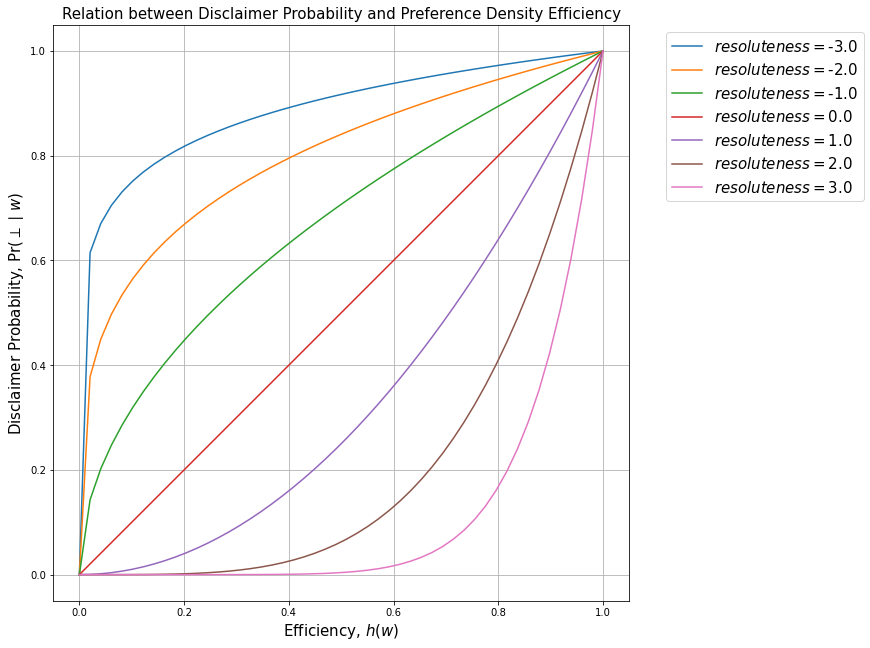

In [12]:
# Illustration for Simulation Assumption 4

import numpy as np
import matplotlib.pyplot as plt

rs:List[int] = [pow(2, ic) for ic in range(-3,4)]
h:np.ndarray = np.linspace(0,1)
p:np.ndarray = np.transpose([pow(h, r) for r in rs])
    
fig:plt.Figure = plt.figure(figsize=(8.0,8.0))
ax:plt.axes = fig.add_axes([0.0, 0.0, 1.0, 1.0])
    
ax.set_xlabel("Efficiency, $h(w)$", fontsize=15)
ax.set_ylabel("Disclaimer Probability, $\Pr(\perp\mid w)$", fontsize=15) 

for i in range(len(rs)):
    ax.plot(h, p[:, i], label=f"$resoluteness=${np.log2(rs[i])}")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
    
plt.title("Relation between Disclaimer Probability and "
          "Preference Density Efficiency",
          fontsize=15)
plt.grid(True)
plt.show()

## **Simulate connection between actors**

The task is to realize communication between two nodes in graph $G(N, E)$ with some probability. It must be emphasized that two nodes $e_1$ and $e_2$ can communicate with each other only if $(e_1, e_2) \in E$.  
There is the way to solve this task:
- $p$ is default probability for connection;
- $P$ is set of pairs like $(e_1, e_2)$, where edge $(e_1, e_2)$ has different probability for connection;
- $\sigma:P \to [0, 1]$ is mapping, which associates pair from $P$ with its connection probability;

Total probability for each edge $e \in E$ is following:
- $\sigma(e)$, if $e \in P$
- $p$, if $e \notin P$

Program realization using `Python`, `NetworkX` and `NumPy`:

In [13]:
from typing import Dict, Tuple, Callable as callable_obj
from copy import copy
from collections.abc import Callable
from random import random
from pprint import pprint

import networkx as nx
import matplotlib.pyplot as plt

def model_communication(society:nx.Graph=None,
                        default_prob:float=0.5,
                        special_probs:Dict[tuple, float]=None,
                        result_func:callable_obj[[tuple], dict]=lambda edge: dict()) -> nx.Graph:
    '''
    Function, that models communication between nodes in graph.
    
    Communication between each pair of nodes is comitted
    with probability default_prob or identified in special_probs.
    
    Arguments:
        • society:nx.Graph - graph for experiment;
          required argument;
        • default_prob:[float, int] - probability to connect edges;
          optional argument, default value is 0.5;
        • special_probs:Dict[tuple, prob] - unique probabilities.
              • keys of this dict are tuples like (a, b), where a and b are
                nodes of society;
              • values of this dict are probabilities to commit communication;
          optional argument, default value is empty dict - {};
        • result_func:Callable[[tuple], dict] - function to process edge.
            • has to return object of type dict;
          optional argument, default value is lambda edge: dict();
            
    Returns:
        • society:nx.Graph - updated graph with new edges. 
        
    It is important, that function does not change passed graph.
    '''
    
    # preprocess society argument
    if not isinstance(society, nx.Graph):
        raise TypeError('society argument is not passed or is not of type nx.Graph.')
        
    # preprocess default_prob argument
    if not (isinstance(default_prob, int) or isinstance(default_prob, float)):
        raise TypeError('default_prob argument is not of type int or float.')
        
    if not (0 <= default_prob <= 1):
        raise ValueError(f'default_prob has to be in [0, 1] (got {default_prob}).')
        
    # preprocess result_func argument:
    if not isinstance(result_func, Callable):
        raise TypeError(f'result_func argument is not of type Callable (got {type(result_func)}).')
        
    # preprocess special_probs argument
    if not (isinstance(special_probs, dict) or special_probs is None):
        raise TypeError('special_probs argument is not of type dict or NoneType.')
    
    # convert special_probs to dict if it is of type NoneType
    if special_probs is None:
        special_probs:Dict[Tuple, prob] = dict()
    
    # copy graph to avoid changing given
    society:nx.Graph = copy(society)
        
    # validate special_probs argument
    for edge, prob in special_probs.items():
        
        # preprocess keys
        if not isinstance(edge, tuple):
            raise TypeError(f'{edge} in special_probs is not of type tuple (got {type(edge)}.')
            
        if len(edge) != 2:
            raise TypeError(f'{edge} in special_probs has not lenght equal to 2 (got {len(edge)}).')
            
        # unpack tuple to nodes
        e1, e2 = edge
        
        # check are nodes in graph
        if e1 not in society.nodes:
            raise ValueError(f'{e1} in special_probs argument is not in society argument.')
            
        if e2 not in society.nodes:
            raise ValueError(f'{e2} in special_probs argument is not in society argument.')
            
        # validate probability
        if not (isinstance(prob, int) or isinstance(prob, float)):
            raise TypeError(f'{prob} in special_probs argument is not of type int or float (got {type(prob)}).')
            
        if not (0 <= prob <= 1):
            raise ValueError(f'prob in special_probs argument has to be in [0, 1] (got {prob}).')
            
    # start experiment
    for edge in graph.edges(data=True):
        
        # unpack edge data
        e1, e2, data = edge
        
        # get special prob
        if (e1, e2) in special_probs:
            prob:float = special_probs[(e1, e2)]
        else:
            prob:float = default_prob
                
        # communication between two edges is completed
        if random() <= prob:
            
            # call result_funct for current edge
            try:
                update:dict = result_func(edge)
            except Exception as ex:
                raise TypeError(f'result_func is not needed function to call ({ex}).')
                
            if not isinstance(update, dict):
                raise TypeError(f'Wrong returning type (expected dict, got {type(update)})')
                
            # update edge
            for key in update:
                society.edges[(e1, e2)][key] = update[key]
                
    return society

There is example of using `model_communication` function. Following code snippet models communication for completed graph with 5 nodes. Default communication probability is equal to $0.5$, and communication probability for nodes $0$ and $1$ is equal to 1. Experiment is made for $100$ iterations. For each edge model saves number of completed communications.

In [14]:
# create completed graph with 5 nodes
graph:nx.Graph = nx.complete_graph(5)
    
# each edge in graph is {'count': 0}
for edge in graph.edges:
    graph.edges[edge]['count'] = 0
    
def preprocess(edge_data:tuple) -> dict:
    '''
    Increments 'count' field in edge data.
    
    Arguments:
        edge_data:Tuple[obj, obj, dict] - tuple with 3 elements: (node1, node2, data:dict);
    Returns:
        new_data:dict - new dict, where data.count = data.count + 1;
    '''
    
    # unpack nodes and data
    e1, e2, data = edge_data
    
    # copy dict
    data:Dict[str, [float, int]] = dict(data)
    
    # increment 'count' field
    data['count']:int = data['count'] + 1
    
    return data

# configure params for experiment
params_grid:Dict[str, float]= {'society':graph,
                               'default_prob':0.5,
                               'special_probs':{(0, 1):1},
                               'result_func':preprocess}

for i in range(100):
    graph = model_communication(**params_grid)

pprint(list(graph.edges(data=True)))

[(0, 1, {'count': 100}),
 (0, 2, {'count': 55}),
 (0, 3, {'count': 52}),
 (0, 4, {'count': 51}),
 (1, 2, {'count': 50}),
 (1, 3, {'count': 45}),
 (1, 4, {'count': 57}),
 (2, 3, {'count': 47}),
 (2, 4, {'count': 54}),
 (3, 4, {'count': 43})]


Next follows visualization of obtained graph using `matplotlib`.

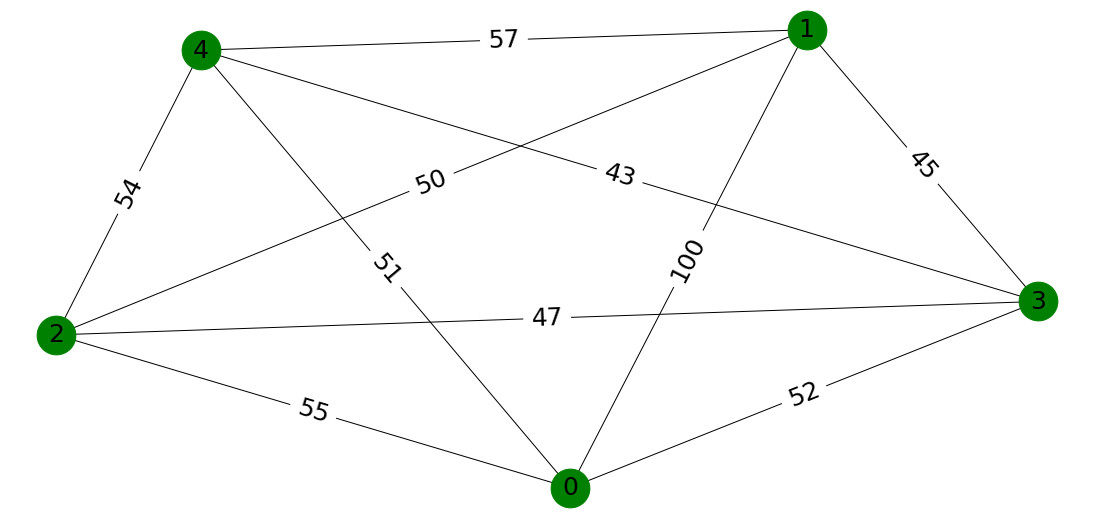

In [15]:
layout = nx.spring_layout(graph)

plt.figure(figsize=(15, 7))

nx.draw(graph,layout,
        node_size=1500,
        edge_color='black',
        width=1,
        linewidths=1,
        node_color='green',
        labels={node:node for node in graph.nodes()},
        font_size=25)

nx.draw_networkx_edge_labels(graph, 
                             layout, 
                             edge_labels={(e1, e2):data['count']
                                          for e1, e2, data in graph.edges(data=True)},
                             font_size=25)
plt.axis('off')
plt.show()